In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Reference Model

In [20]:
# Loading trajectory
results=pd.read_csv('Resultscounty.txt',header=None,sep='\t')
results.columns=['ID','time','county','S','E','A','I','R','P','D']
# results=pd.merge(results,parameters,on='ID')
results.sort_values(['ID','time'],ascending=True,inplace=True)
dictionary=pd.read_csv('countydictionary.csv')
dictionary.columns=['COUNTY CODE','COUNTY NAME','county']
results=pd.merge(results,dictionary,on='county')
# results=resultspatch[['time','COUNTY NAME','S','E','A','I','R','P','D','beta','tauexposed','taupresymp','tauI','casefatalityrate','COUNTY CODE']]  
results=results[['ID','time','COUNTY NAME','S','E','A','I','R','P','D']]
results.loc[:,"S":"D"] = results.loc[:,"S":"D"].div(results.loc[:,"S":"D"].sum(axis =1), axis=0)
population =pd.read_csv('popCounty.txt',index_col=False,names=['ID','Population'],header=None,sep=' ')['Population'].tolist()
area =pd.read_csv('areaCounty.txt',index_col=False,names=['ID','Area'],header=None,sep=' ')['Area'].tolist()
# Getting number of patches
patches = np.unique(results['COUNTY NAME'].values)
M = len(patches)
# Getting the time length
time = np.unique(results['time'].values)
T = len(time)
# Getting number of trajectories
IDs = np.unique(results['ID'].values)
N = len(IDs)
np.set_printoptions(threshold=np.inf)
# Number of compartments
C = 7
ref_traj = np.empty((N, T, M, C))
for n in IDs:
    for m, patch_name in enumerate(patches):
        ID = results.loc[results['ID'].isin([str(n)])]
        county = ID.loc[ID['COUNTY NAME'] == patch_name]
        traj_county = county[['S','E','A','I','R','P','D']].to_numpy()
        ref_traj[n,:,m,:] = traj_county
print (np.shape(ref_traj))

(10, 201, 62, 7)


Plotting 62 patches in a 7 x 9 grid


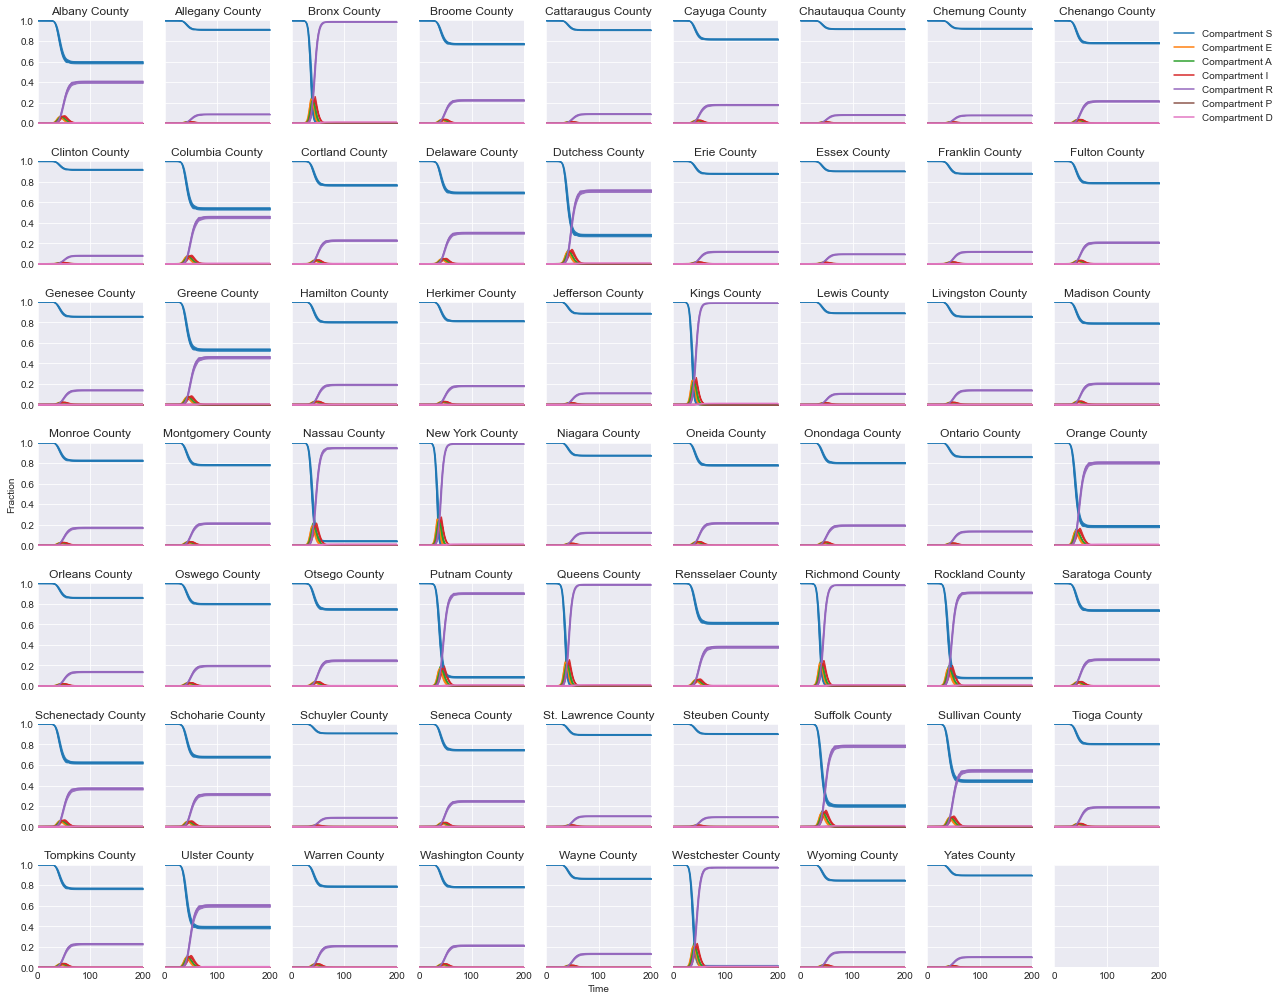

In [3]:
patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.9, names=['S','E','A','I','R','P','D'])
plt.savefig('patch_quantile.png',dpi=400)
plt.show()

In [21]:
# Run this for creating frames for animations
import plotly.graph_objs as go
import plotly.figure_factory as ff 
process_traj = False
if process_traj == True:
    for t in range(T):
        infected_portion = [round(ref_traj[0,t,i,3],2) for i in range(M)]
        zipcodes = dictionary['COUNTY CODE']
        fig = ff.create_choropleth(fips=zipcodes, 
                                   scope=['New York'],
                                   values=infected_portion,
                                   title='NY COVID-19 Infected Population Fraction by County',
                                   county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
                                   state_outline={'width': .5}
                                   )


        fig.update_layout(legend=dict(
            title='Infected Fraction',
            yanchor="top",
            y=0.95,
            xanchor="left",
            x=0.9,

        ))
        fig.add_annotation(dict(font=dict(color='black',size=30),
                                                x=0.4,
                                                y=0.12,
                                                showarrow=False,
                                                text="Day {}".format(t),
                                                textangle=0,
                                                xanchor='left',
                                                xref="paper",
                                                yref="paper"
                                                ))

        fig.layout.template = {'layout': {'font': {'family': 'Britannic Bold', 'size': 20}}}
        fig.write_image("NY_map//traj_" + str(t) +
                            ".png",width = 2048, height =1060)

In [22]:
# Run this for saving plots
if process_traj == True:
    for i in range(M):
        traj_quantile(ref_traj[:,:,i,:], names=['S','E','A','I','R','P','D'], add_legend=False, add_title = patches[i], plot_means=True)
        fig = plt.gcf()
        fig.set_size_inches(4, 4)
        #plt.savefig('{}.png'.format(patches[i]),dpi=400)
        plt.close()

In [23]:
# load mobility matrix
networkCounty=pd.read_csv('networkCounty.txt',header=None,sep=' ')
networkCounty.columns=['ID','County','mobility_parameter']
mobility_matrix = networkCounty.reset_index().groupby(['County'])['mobility_parameter'].apply(np.array).to_numpy()
networkCounty = networkCounty[['ID','mobility_parameter']]
Mobility_martix = np.empty([0,M])
mobility_parameter_row = np.zeros(M)
for i,row in networkCounty.iterrows():
    mobility_parameter_row[networkCounty.loc[i, 'ID']] = networkCounty.loc[i, 'mobility_parameter']
    if i < networkCounty.shape[0]-1:
        if networkCounty.loc[i+1, 'ID'] == 0:
            Mobility_martix = np.append(Mobility_martix, [mobility_parameter_row], axis=0)
            mobility_parameter_row = np.zeros(M)
    else:
         Mobility_martix = np.append(Mobility_martix, [mobility_parameter_row], axis=0)
assert (np.shape(Mobility_martix)==(M,M))
Mobility_martix_norm = Mobility_martix / np.sum(Mobility_martix, axis=1).reshape(M,1)

## Restraining a sample SEAIRPD to reference

In [24]:
# compartment parameters
compartments = ['E','A','I','R','P','D']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 5, 2)
tmat.add_transition('A', 'I', 3, 1)
tmat.add_transition('I', 'P', 5, 2)
tmat.add_transition('P', 'D', 5, 2)
tmat.add_transition('D', 'R', 5, 2)

print(tmat.value)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_low = 0.0001
hyper_pram.beta_high = 0.9
hyper_pram.beta_var = 0.1
hyper_pram.start_high = 0.01
# hyper_pram.start_var = 0.1
# hyper_pram.R_var = 0.001
hyper_pram.beta_start = 0.001
hyper_pram.start_mean = 0.001
# hyper_pram.start_scale = 0.1

start_logits = np.zeros((M,))
start_logits[:]=np.log(0.01)
param_model = maxentep.MetaParameterJoint(start_logits, Mobility_martix_norm , tmat, name='unbiased_model',hypers = hyper_pram )

[[0.8        0.2        0.         0.         0.         0.        ]
 [0.         0.66666667 0.33333333 0.         0.         0.        ]
 [0.         0.         0.8        0.         0.2        0.        ]
 [0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.8        0.2       ]
 [0.         0.         0.         0.2        0.         0.8       ]]


In [25]:
import tqdm
N = 256
batches = 16
outs = []
infect = maxentep.contact_infection_func(infections_compartments,area = area)
model = maxentep.MetaModel(infect, T,populations = np.round(population))
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:37<00:00,  2.32s/it]


(4096, 201, 62, 7)


## Make restraints from reference trajectory

73 0.42190920524839204 0.42190920524839204
31 0.0007101739128039031 0.0007101739128039031
115 0.42545302906246046 0.42545302906246046
87 0.4253157041559711 0.4253157041559711
52 0.25897433740653264 0.25897433740653264
45 0.10667882630991607 0.10667882630991607
136 0.42545316070350975 0.42545316070350975
3 0.0 0.0
17 1.043558436212753e-05 1.043558436212753e-05
24 0.0003160689682225051 0.0003160689682225051
31 0.008031429653266253 0.008031429653266253
10 3.2322611430587604e-07 3.2322611430587604e-07
38 0.0512578702433315 0.0512578702433315
45 0.05707742946318251 0.05707742946318251
3 0.0 0.0
59 0.0064952734447155805 0.0064952734447155805
52 0.04193451498318427 0.04193451498318427
24 0.0001304448261902567 0.0001304448261902567
10 9.235031624096221e-08 9.235031624096221e-08
31 0.0036144989122980672 0.0036144989122980672
59 0.013995041067532521 0.013995041067532521
17 4.294289145516756e-06 4.294289145516756e-06
38 0.037327199152681886 0.037327199152681886
66 0.0032790820187091818 0.00327908

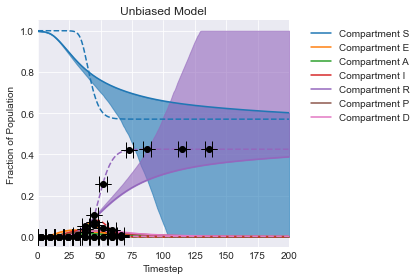

In [46]:
# Plotting restraints on reference traj
full_compartments = ['S'] + compartments
p = 1 # picking one trajectory from the parameter set
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[p,:,0], linestyle='--')
plt.title('Unbiased Model')

npoints =8
prior = maxentep.Laplace(0.1)
# cutting the ref_traj in half
restraints_R, plot_fxn_R = maxentep.traj_to_restraints(ref_traj[p,:150,:,:], [0,4], npoints, prior, noise=0,time_average=7)
restraints_E, plot_fxn_E = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,1], npoints, prior, noise=0,time_average=7)
restraints_A, plot_fxn_A = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,2], npoints, prior, noise=0,time_average=7)
restraints_I, plot_fxn_I = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,3], npoints, prior, noise=0,time_average=7)
restraints_P, plot_fxn_P = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,5], npoints, prior, noise=0,time_average=7)
restraints_D, plot_fxn_D = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,6], npoints, prior, noise=0,time_average=7)
restraints = restraints_R + restraints_E + restraints_A + restraints_I + restraints_P + restraints_D
plot_fxns = plot_fxn_R + plot_fxn_E + plot_fxn_A + plot_fxn_I + plot_fxn_P + plot_fxn_D
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.tight_layout()
plt.savefig('unbiased.png',dpi=200)
plt.show()


In [64]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [65]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [66]:
history = me_model.fit(trajs, batch_size=8,epochs=50, callbacks=[CustomCallback()])

Epoch 1/50
512/512 [==============================] - 0s 444us/step - loss: 0.0042 - weight-entropy: 2.0517
Epoch 2/50
512/512 [==============================] - 0s 440us/step - loss: 0.0042 - weight-entropy: 2.0468
Epoch 3/50
512/512 [==============================] - 0s 456us/step - loss: 0.0042 - weight-entropy: 2.0450
Epoch 4/50
512/512 [==============================] - 0s 448us/step - loss: 0.0038 - weight-entropy: 2.0435
Epoch 5/50
512/512 [==============================] - 0s 452us/step - loss: 0.0041 - weight-entropy: 2.0455
Epoch 6/50
512/512 [==============================] - 0s 448us/step - loss: 0.0038 - weight-entropy: 2.0427
Epoch 7/50
512/512 [==============================] - 0s 438us/step - loss: 0.0040 - weight-entropy: 2.0408
Epoch 8/50
512/512 [==============================] - 0s 452us/step - loss: 0.0042 - weight-entropy: 2.0415
Epoch 9/50
512/512 [==============================] - 0s 450us/step - loss: 0.0038 - weight-entropy: 2.0470
Epoch 10/50
512/512 [=======

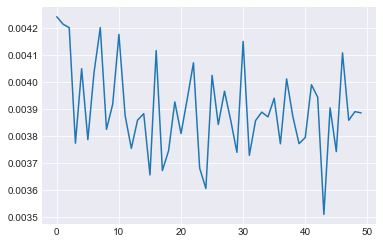

In [67]:
plt.plot(history.history['loss'])

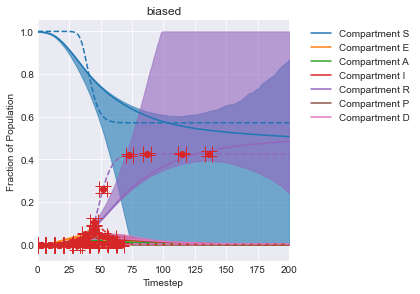

In [68]:
patch_number = 0
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(plt, me_model.lambdas[i], color='C3')
plt.tight_layout()
plt.title('biased')
plt.show()

In [32]:
weights = me_model.traj_weights
# plt.hist(weights)
# plt.show()
# plt.plot(me_model.lambdas.numpy(), 'o')

In [33]:
print (weights)

tf.Tensor(
[0.00059532 0.00021573 0.00021573 0.00037562 0.00026982 0.00026347
 0.00021573 0.00021573 0.00021573 0.00040964 0.00021573 0.00021573
 0.00022792 0.00021581 0.00023652 0.00021573 0.0002161  0.00021897
 0.00065571 0.00021573 0.00021573 0.00021573 0.00023763 0.00011908
 0.00037268 0.00021585 0.00021573 0.00021573 0.0002723  0.00048384
 0.00023158 0.00026665 0.00016245 0.00021573 0.0003167  0.00021573
 0.00021573 0.00021573 0.00021997 0.00039178 0.00036207 0.0003473
 0.00021615 0.00023328 0.00021573 0.00021573 0.00023804 0.00021573
 0.00021573 0.00023092 0.00035275 0.00021573 0.00021573 0.00032598
 0.00021573 0.0002577  0.0001808  0.00021573 0.00021573 0.00025813
 0.0003349  0.00028646 0.00021573 0.00021573 0.00053762 0.00021573
 0.00021573 0.00021573 0.00021575 0.00051628 0.00021573 0.00023036
 0.00021573 0.0002808  0.00029679 0.00021421 0.00026219 0.00037443
 0.00021573 0.00021573 0.00021571 0.00022617 0.00025051 0.00021573
 0.00021573 0.00031894 0.0002388  0.00021573 0.00021

## Algorithm 2

In [71]:
fit_param_model = maxentep.MetaParameterJoint(np.zeros((M,)), Mobility_martix_norm, tmat, name='unbiased_model',hypers = hyper_pram)
fit_param_model.compile(tf.optimizers.Adam(0.001))
hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model)
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), 'mean_squared_error')

In [72]:
history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=25, batch_size=32, epochs=8)

Epoch 1/8
8/8 [==============================] - 0s 750us/step - loss: 0.0413 - weight-entropy: 3.4125
Epoch 2/8
8/8 [==============================] - 0s 623us/step - loss: 0.0409 - weight-entropy: 3.4151
Epoch 3/8
8/8 [==============================] - 0s 876us/step - loss: 0.0404 - weight-entropy: 3.4200
Epoch 4/8
8/8 [==============================] - 0s 623us/step - loss: 0.0398 - weight-entropy: 3.4239
Epoch 5/8
8/8 [==============================] - 0s 748us/step - loss: 0.0393 - weight-entropy: 3.4271
Epoch 6/8
8/8 [==============================] - 0s 744us/step - loss: 0.0385 - weight-entropy: 3.4320
Epoch 7/8
8/8 [==============================] - 0s 624us/step - loss: 0.0380 - weight-entropy: 3.4342
Epoch 8/8
8/8 [==============================] - 0s 627us/step - loss: 0.0375 - weight-entropy: 3.4371
Epoch 1/8
8/8 [==============================] - 0s 4ms/step - loss: 1.8916 - R-dist-dist_loss: 2.0895 - T-dist-dist_loss: -0.0176 - rho-dist-dist_loss: -0.0020 - beta-dist_los

8/8 [==============================] - 0s 873us/step - loss: 0.0332 - weight-entropy: 1.4934
Epoch 7/8
8/8 [==============================] - 0s 874us/step - loss: 0.0342 - weight-entropy: 1.4854
Epoch 8/8
8/8 [==============================] - 0s 748us/step - loss: 0.0403 - weight-entropy: 1.1198
Epoch 1/8
8/8 [==============================] - 0s 4ms/step - loss: 1.9022 - R-dist-dist_loss: 2.1104 - T-dist-dist_loss: -0.0194 - rho-dist-dist_loss: -0.0034 - beta-dist_loss: -0.1855
Epoch 2/8
8/8 [==============================] - 0s 4ms/step - loss: 1.8876 - R-dist-dist_loss: 2.0960 - T-dist-dist_loss: -0.0194 - rho-dist-dist_loss: -0.0035 - beta-dist_loss: -0.1855
Epoch 3/8
8/8 [==============================] - 0s 4ms/step - loss: 1.8620 - R-dist-dist_loss: 2.0705 - T-dist-dist_loss: -0.0194 - rho-dist-dist_loss: -0.0037 - beta-dist_loss: -0.1855
Epoch 4/8
8/8 [==============================] - 0s 4ms/step - loss: 1.8402 - R-dist-dist_loss: 2.0489 - T-dist-dist_loss: -0.0194 - rho-dis

8/8 [==============================] - 0s 4ms/step - loss: 1.6687 - R-dist-dist_loss: 1.8987 - T-dist-dist_loss: -0.0196 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.2075
Epoch 5/8
8/8 [==============================] - 0s 4ms/step - loss: 1.6337 - R-dist-dist_loss: 1.8640 - T-dist-dist_loss: -0.0197 - rho-dist-dist_loss: -0.0030 - beta-dist_loss: -0.2075
Epoch 6/8
8/8 [==============================] - 0s 4ms/step - loss: 1.5997 - R-dist-dist_loss: 1.8302 - T-dist-dist_loss: -0.0198 - rho-dist-dist_loss: -0.0032 - beta-dist_loss: -0.2075
Epoch 7/8
8/8 [==============================] - 0s 4ms/step - loss: 1.5725 - R-dist-dist_loss: 1.8033 - T-dist-dist_loss: -0.0198 - rho-dist-dist_loss: -0.0034 - beta-dist_loss: -0.2075
Epoch 8/8
8/8 [==============================] - 0s 3ms/step - loss: 1.5438 - R-dist-dist_loss: 1.7748 - T-dist-dist_loss: -0.0199 - rho-dist-dist_loss: -0.0036 - beta-dist_loss: -0.2075
Epoch 1/8
8/8 [==============================] - 0s 624us/step - loss: 0.03

8/8 [==============================] - 0s 3ms/step - loss: 1.6233 - R-dist-dist_loss: 1.8500 - T-dist-dist_loss: -0.0186 - rho-dist-dist_loss: 8.8869e-04 - beta-dist_loss: -0.2090    
Epoch 1/8
8/8 [==============================] - 0s 873us/step - loss: 0.0290 - weight-entropy: 0.7073
Epoch 2/8
8/8 [==============================] - 0s 873us/step - loss: 0.0270 - weight-entropy: 0.5894
Epoch 3/8
8/8 [==============================] - 0s 997us/step - loss: 0.0269 - weight-entropy: 0.6160
Epoch 4/8
8/8 [==============================] - 0s 872us/step - loss: 0.0267 - weight-entropy: 0.4781
Epoch 5/8
8/8 [==============================] - 0s 748us/step - loss: 0.0259 - weight-entropy: 0.5946
Epoch 6/8
8/8 [==============================] - 0s 872us/step - loss: 0.0214 - weight-entropy: 0.6501
Epoch 7/8
8/8 [==============================] - 0s 743us/step - loss: 0.0235 - weight-entropy: 0.4607
Epoch 8/8
8/8 [==============================] - 0s 873us/step - loss: 0.0202 - weight-entropy:

8/8 [==============================] - 0s 748us/step - loss: 0.0275 - weight-entropy: 0.5109
Epoch 1/8
8/8 [==============================] - 0s 4ms/step - loss: 1.5800 - R-dist-dist_loss: 1.8585 - T-dist-dist_loss: -0.0159 - rho-dist-dist_loss: -0.0078 - beta-dist_loss: -0.2547
Epoch 2/8
8/8 [==============================] - 0s 4ms/step - loss: 1.5064 - R-dist-dist_loss: 1.7857 - T-dist-dist_loss: -0.0160 - rho-dist-dist_loss: -0.0086 - beta-dist_loss: -0.2547    
Epoch 3/8
8/8 [==============================] - 0s 4ms/step - loss: 1.4221 - R-dist-dist_loss: 1.7023 - T-dist-dist_loss: -0.0161 - rho-dist-dist_loss: -0.0094 - beta-dist_loss: -0.2547    
Epoch 4/8
8/8 [==============================] - 0s 4ms/step - loss: 1.3510 - R-dist-dist_loss: 1.6320 - T-dist-dist_loss: -0.0161 - rho-dist-dist_loss: -0.0102 - beta-dist_loss: -0.2547        
Epoch 5/8
8/8 [==============================] - 0s 3ms/step - loss: 1.2886 - R-dist-dist_loss: 1.5703 - T-dist-dist_loss: -0.0162 - rho-dist-d

8/8 [==============================] - 0s 3ms/step - loss: 1.8254 - R-dist-dist_loss: 2.0921 - T-dist-dist_loss: -0.0138 - rho-dist-dist_loss: -0.0036 - beta-dist_loss: -0.2492    
Epoch 7/8
8/8 [==============================] - 0s 3ms/step - loss: 1.7877 - R-dist-dist_loss: 2.0547 - T-dist-dist_loss: -0.0139 - rho-dist-dist_loss: -0.0038 - beta-dist_loss: -0.2492        
Epoch 8/8
8/8 [==============================] - 0s 3ms/step - loss: 1.7347 - R-dist-dist_loss: 2.0021 - T-dist-dist_loss: -0.0140 - rho-dist-dist_loss: -0.0041 - beta-dist_loss: -0.2492
Epoch 1/8
8/8 [==============================] - 0s 748us/step - loss: 0.0291 - weight-entropy: 0.4235
Epoch 2/8
8/8 [==============================] - 0s 875us/step - loss: 0.0204 - weight-entropy: 0.3674
Epoch 3/8
8/8 [==============================] - 0s 748us/step - loss: 0.0270 - weight-entropy: 0.4223
Epoch 4/8
8/8 [==============================] - 0s 622us/step - loss: 0.0221 - weight-entropy: 0.4739
Epoch 5/8
8/8 [==========

8/8 [==============================] - 0s 877us/step - loss: 0.0308 - weight-entropy: 0.5242
Epoch 5/8
8/8 [==============================] - 0s 748us/step - loss: 0.0243 - weight-entropy: 0.5390
Epoch 6/8
8/8 [==============================] - 0s 873us/step - loss: 0.0346 - weight-entropy: 0.3820
Epoch 7/8
8/8 [==============================] - 0s 748us/step - loss: 0.0309 - weight-entropy: 0.3664
Epoch 8/8
8/8 [==============================] - 0s 749us/step - loss: 0.0274 - weight-entropy: 0.9612
Epoch 1/8
8/8 [==============================] - 0s 4ms/step - loss: 1.9595 - R-dist-dist_loss: 2.2425 - T-dist-dist_loss: -0.0251 - rho-dist-dist_loss: 6.6842e-04 - beta-dist_loss: -0.2585         
Epoch 2/8
8/8 [==============================] - 0s 5ms/step - loss: 1.9088 - R-dist-dist_loss: 2.1920 - T-dist-dist_loss: -0.0251 - rho-dist-dist_loss: 4.4247e-04 - beta-dist_loss: -0.2585             
Epoch 3/8
8/8 [==============================] - 0s 5ms/step - loss: 1.8088 - R-dist-dist_los

8/8 [==============================] - 0s 5ms/step - loss: 1.9326 - R-dist-dist_loss: 2.0521 - T-dist-dist_loss: -0.0170 - rho-dist-dist_loss: 7.0458e-04 - beta-dist_loss: -0.1032             
Epoch 4/8
8/8 [==============================] - 0s 5ms/step - loss: 1.8921 - R-dist-dist_loss: 2.0118 - T-dist-dist_loss: -0.0170 - rho-dist-dist_loss: 4.6662e-04 - beta-dist_loss: -0.1032 
Epoch 5/8
8/8 [==============================] - 0s 5ms/step - loss: 1.8525 - R-dist-dist_loss: 1.9725 - T-dist-dist_loss: -0.0171 - rho-dist-dist_loss: 2.3445e-04 - beta-dist_loss: -0.1032
Epoch 6/8
8/8 [==============================] - 0s 5ms/step - loss: 1.8063 - R-dist-dist_loss: 1.9266 - T-dist-dist_loss: -0.0171 - rho-dist-dist_loss: -5.1225e-05 - beta-dist_loss: -0.1032    
Epoch 7/8
8/8 [==============================] - 0s 4ms/step - loss: 1.7717 - R-dist-dist_loss: 1.8922 - T-dist-dist_loss: -0.0171 - rho-dist-dist_loss: -2.7403e-04 - beta-dist_loss: -0.1032            
Epoch 8/8
8/8 [=============

In [73]:
history.history.keys()

dict_keys(['loss', 'weight-entropy', 'prior-loss', 'prior-R-dist-dist_loss', 'prior-T-dist-dist_loss', 'prior-rho-dist-dist_loss', 'prior-beta-dist_loss'])

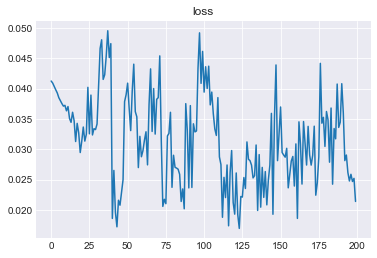

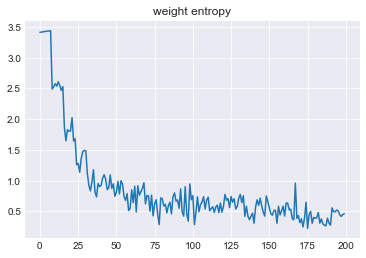

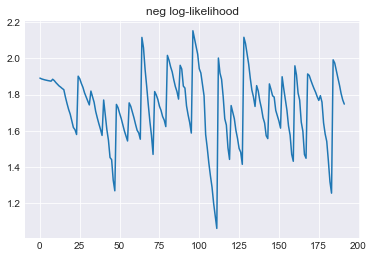

In [74]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()

plt.plot(history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

In [75]:
fit_param_model.get_layer('beta').trainable_variables,param_model.get_layer('beta').trainable_variables

([<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-6.9077554]], dtype=float32)>],
 [<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-6.9077554]], dtype=float32)>])

In [76]:
fit_param_model.summary()

Model: "unbiased_model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (None, 2, 62, 62)    7688        input_11[0][0]                   
__________________________________________________________________________________________________
R-dist-jitter (Lambda)          (None, 2, 62, 62)    0           R-dist-hypers[0][0]              
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (None, 2, 6, 6)      72          input_11[0][0]                   
_______________________________________________________________________________

In [77]:
fit_param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables,param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables

([<tf.Variable 'value:0' shape=(62,) dtype=float32, numpy=
  array([ 0.0843758 ,  0.11186933,  0.09429336, -0.23606241,  0.02263063,
         -0.02082406, -0.02817306, -0.15354912,  0.04476483,  0.21434489,
          0.16729937,  0.02422483, -0.08876456,  0.067531  , -0.09120577,
          0.26708052, -0.05353312,  0.16507602, -0.10626459, -0.10352848,
          0.0318808 ,  0.07678712, -0.03917224,  0.07846329,  0.25226372,
         -0.01393896,  0.15946074, -0.07463239, -0.1394549 ,  0.03314933,
         -0.01614289,  0.0791434 ,  0.23289953,  0.0227474 , -0.02775602,
          0.00735803, -0.07768606, -0.00078315,  0.10790646,  0.06761616,
          0.04058436, -0.01791064, -0.06895745,  0.08430256,  0.07765515,
          0.13556503,  0.08107227,  0.01556504, -0.16946004,  0.00270793,
          0.1910464 ,  0.03352922,  0.01122479,  0.01683712,  0.07649247,
         -0.02333309,  0.08159052, -0.17864688, -0.2610434 ,  0.07436397,
          0.16956924, -0.1202243 ], dtype=float32)>],

In [78]:
hme_fit = np.sum((hme_model.restraint_values * hme_model.traj_weights[:,np.newaxis]), axis=0)
me_fit =  np.sum((me_model.restraint_values * me_model.traj_weights[:,np.newaxis]), axis=0)
print(hme_fit, me_fit)
print(np.mean(hme_fit**2), np.mean(me_fit**2))

[-2.51784831e-01  4.16006111e-02 -1.24218635e-01 -2.09922582e-01
 -1.55655757e-01 -2.45191529e-02 -6.76500350e-02  1.11265208e-05
  1.52581567e-02  1.61044467e-02  9.50742606e-03  1.54105015e-02
 -3.29157151e-02 -3.82353738e-02  2.20901333e-02  1.27472794e-02
 -3.14014517e-02  8.96925293e-03  1.09534748e-02  5.93605824e-03
 -3.37566808e-03  9.24954284e-03 -2.73101404e-02  7.34696630e-03
 -7.06858374e-03  1.45204877e-02  1.33074988e-02 -5.48477508e-02
  4.19338467e-03 -1.53215555e-02  7.12078577e-03  1.36261396e-02
  9.28581634e-04  1.42567623e-02  1.41641591e-02  1.40930917e-02
  1.32181514e-02  1.45005928e-02  1.42796552e-02  1.42326411e-02
  1.38791008e-02  8.79611634e-03  1.45237818e-02  1.35813337e-02
  1.42117692e-02  3.23047256e-03  1.22176891e-04  1.43330777e-02] [-1.6573486e-01  1.9198941e-02 -2.0756707e-02 -1.0426483e-01
 -1.3278741e-01 -2.4597315e-02  1.4338261e-02  1.4661852e-06
  1.6268266e-02  2.6382584e-02  2.5671568e-02  6.0499562e-03
 -1.5024703e-02 -2.3005513e-02  2.17

In [79]:
eh = -np.sum(hme_model.traj_weights * np.log(hme_model.traj_weights))
e =  -np.sum(me_model.traj_weights * np.log(me_model.traj_weights))
print('Maxent', e, 'after tuning', eh)

Maxent 8.260448 after tuning 2.3228014


## Direct Regression of Model

In [80]:
T = tmat.value
start = np.zeros((M, C))
start[0,1] = 0.01
infect = maxentep.ContactInfectionLayer(hyper_pram.beta_start, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, Mobility_martix_norm, T, infect, 201, agreement)

In [81]:
rmodel.compile(optimizer=tf.keras.optimizers.Adam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(150)
rtraj = rmodel.get_traj()

150/150 [==============================] - 15s 97ms/step - loss: 0.0972 - output_2_loss: 0.0972 2s - loss:


## Visualizing results

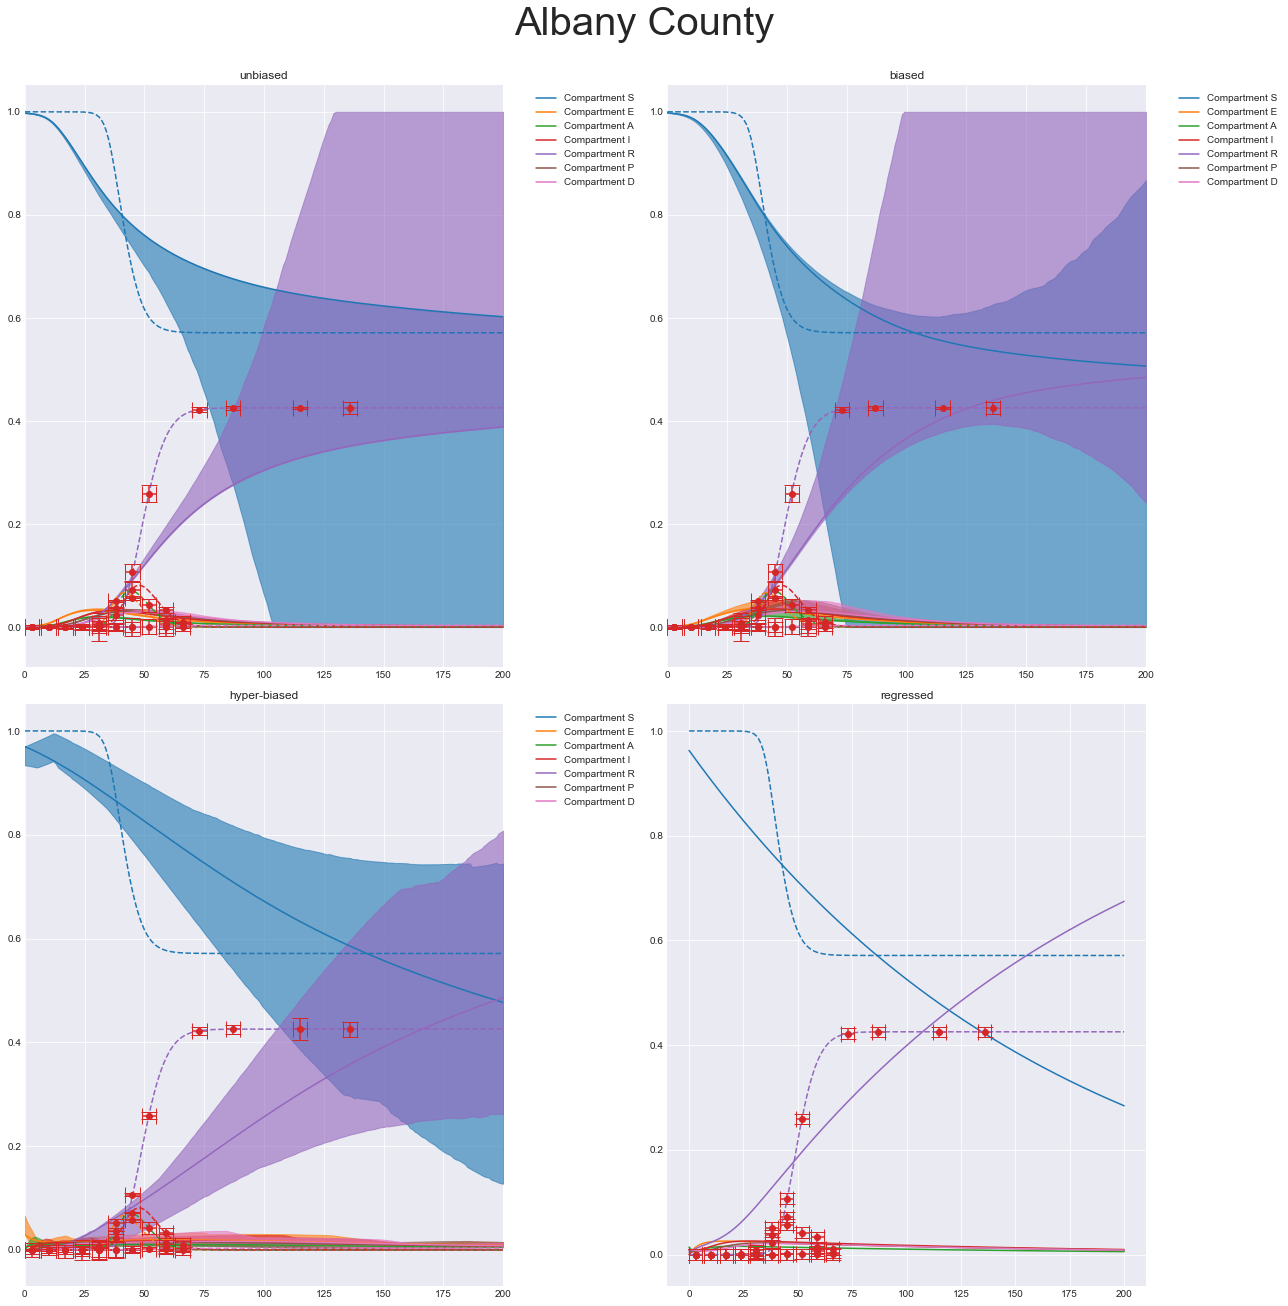

In [90]:
patch_number = 0
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
# plt.savefig('compare_Albany.png', dpi = 300)
plt.show()
plt.close()

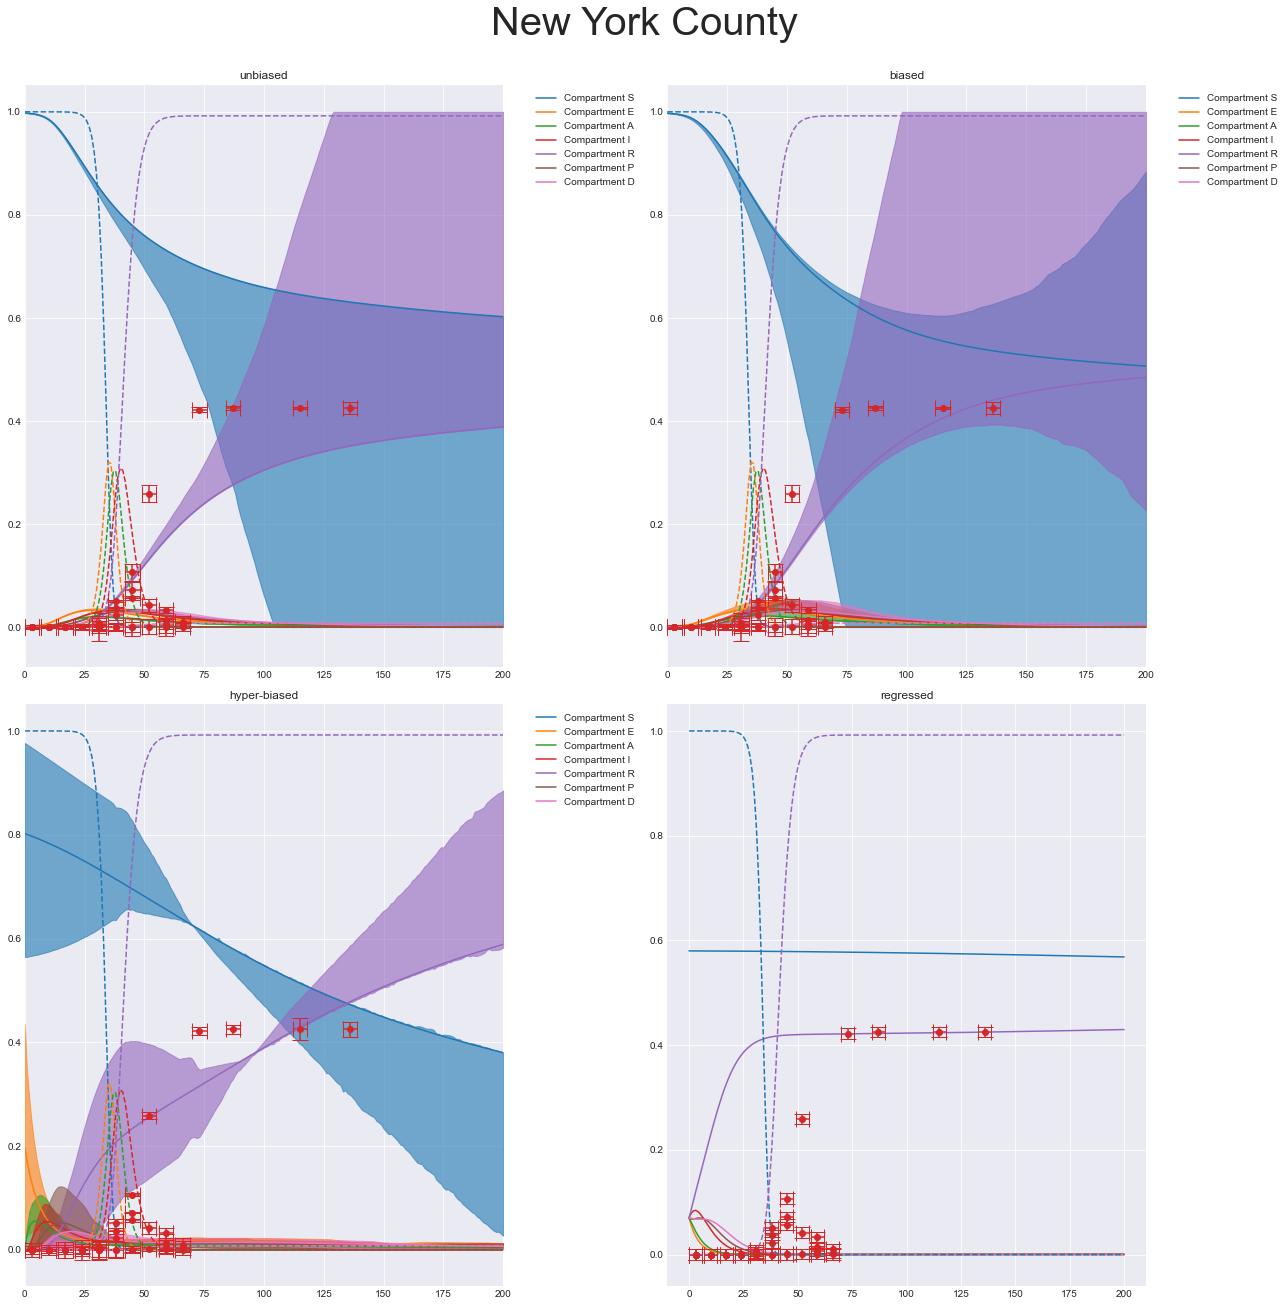

In [91]:
patch_number = 30
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
# plt.savefig('compare_NY.png', dpi = 300)
plt.show()
plt.close()

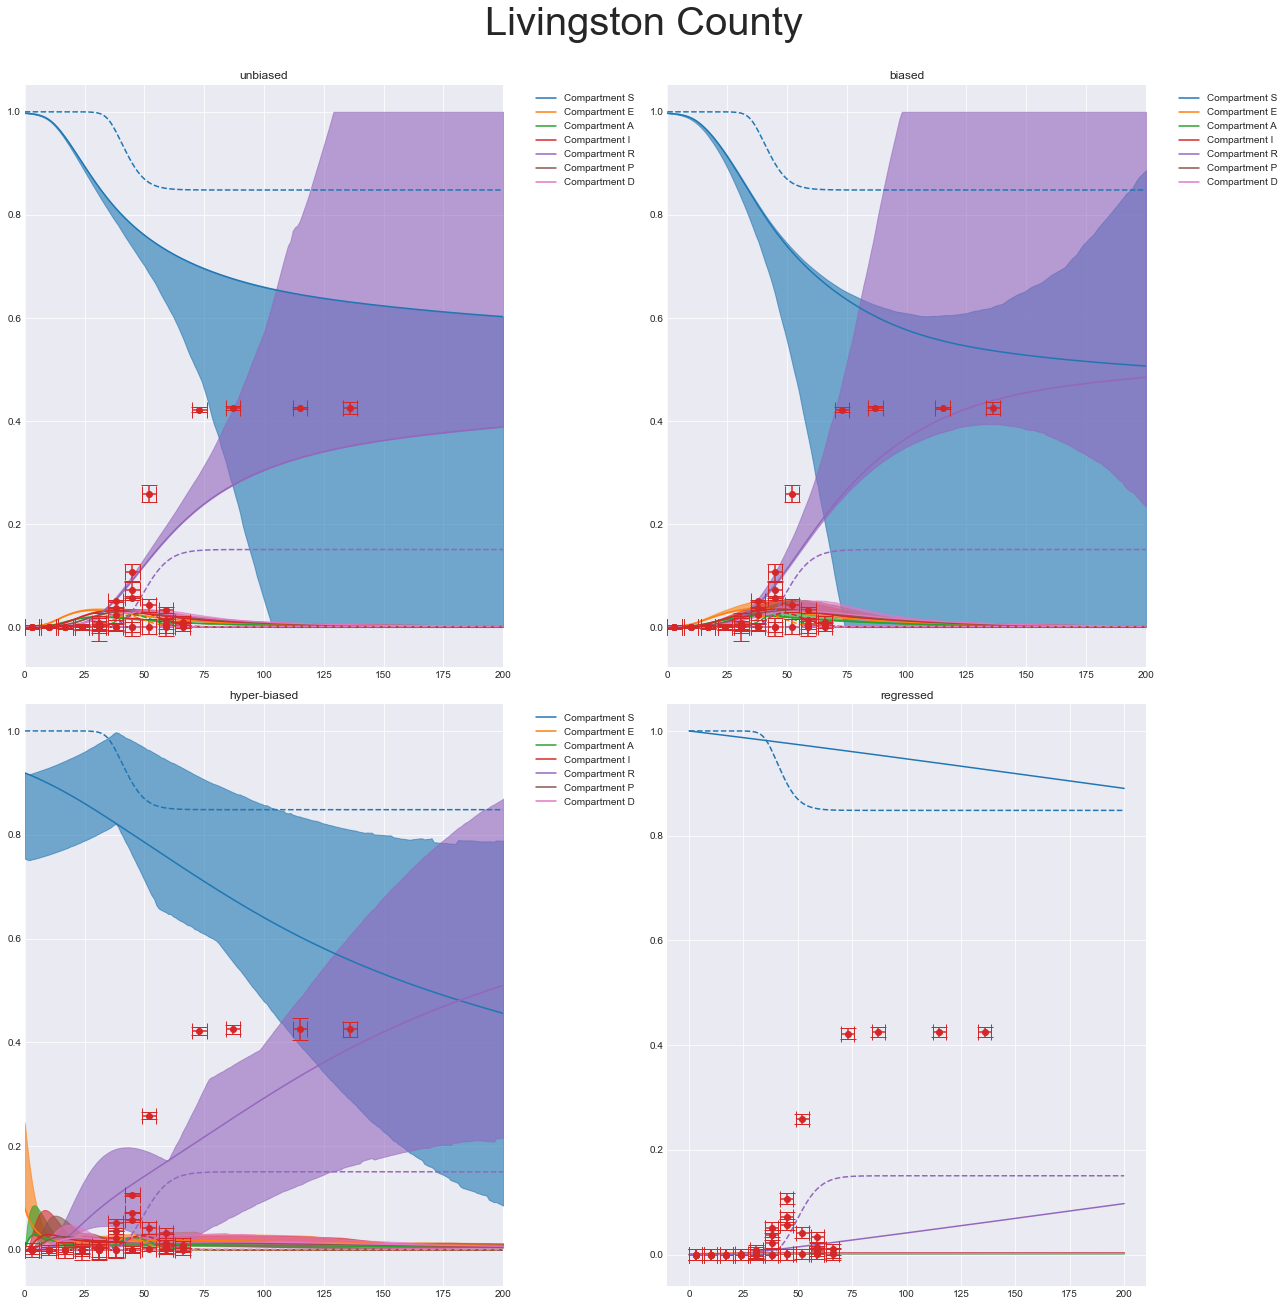

In [94]:
patch_number = 25
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('compare_Livingston.png', dpi = 300)
plt.show()
